In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse

In [55]:
path = "/home/centos/data/cmu_challenge/"

In [3]:
#train = h5py.File(path + "muon_calo_train-val.hdf5") 

In [14]:
def get_data(file_name):
    
    file = h5py.File(path + file_name, "r+")
    cont_feats = json.loads(file['meta_data/cont_feats'][()])
    hl_inputs = file['fold_0/inputs'][()]  # muon x feature numpy array
    targets = file['fold_0/targets'][()]  # muon x 1
    file.close()
    return hl_inputs, targets

In [16]:
X_train, y_train = get_data('muon_calo_train-val.hdf5')

In [17]:
X_test_labelled, y_test_labelled = get_data('muon_calo_test_labelled.hdf5')

In [18]:
X_test, y_test = get_data('muon_calo_test.hdf5')

## Regression with a Boosted Decision Tree with high level features

In [42]:
# create an xgboost regression model
bdt = xgb.XGBRegressor(objective='reg:squarederror')

In [43]:
bdt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
y_pred = bdt.predict(X_test_labelled) # Predictions

In [45]:
y_pred

array([ 763.88055, 7693.5693 , 6075.3896 , ..., 1672.1244 , 5234.692  ,
       4435.0996 ], dtype=float32)

Text(0, 0.5, 'E_pred')

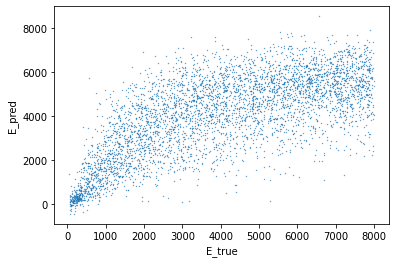

In [51]:
plt.scatter(y_test_labelled, y_pred, s=0.1)
plt.xlabel("E_true")
plt.ylabel("E_pred")

## Neural Network with high and low level features

In [65]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn


In [59]:
class MuonData(Dataset):
    
    def __init__(self, file_name):
        
        file = h5py.File(path + file_name, "r+")
        cont_feats = json.loads(file['meta_data/cont_feats'][()])
        self.hl_inputs = file['fold_0/inputs'][()]  # muon x feature numpy array
        self.targets = file['fold_0/targets'][()]  # muon x 1
        shape = json.loads(file['meta_data/matrix_feats'][()])['shape']
        sparse_hits = file['fold_0/matrix_inputs'][()]
        coords = sparse_hits[1:].astype(int)
        self.hits = sparse.COO(coords=coords, data=sparse_hits[0], shape=[coords[0][-1]+1]+shape).todense()  # muon x 1 x 50 x 32 x 32
        file.close()
        
    def __len__(self):
        return len(targets)
    
    def __getitem__(self, idx): 
        return self.hl_inputs[idx], self.hits[idx], self.targets[idx]


In [60]:
training_data = MuonData('muon_calo_train-val.hdf5')

In [61]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [64]:
for i, (hits, hl_feats, labels) in enumerate(train_dataloader):
    print(hits.shape, hl_feats.shape, labels.shape)
    if i == 5: break

torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])
torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])
torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])
torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])
torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])
torch.Size([64, 28]) torch.Size([64, 1, 50, 32, 32]) torch.Size([64])


In [ ]:

class TwoInputsNet(nn.Module):
    
    def __init__(self):
        super(TwoInputsNet, self).__init__()
        self.conv = nn.Conv2d( ... )  # set up your layer here
        self.fc1 = nn.Linear( ... )  # set up first FC layer
        self.fc2 = nn.Linear( ... )  # set up the other FC layer

    def forward(self, input1, input2):
        c = self.conv(input1)
        f = self.fc1(input2)
        # now we can reshape `c` and `f` to 2D and concat them
        combined = torch.cat((c.view(c.size(0), -1),
                              f.view(f.size(0), -1)), dim=1)
        out = self.fc2(combined)
        return out